In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
!ls

 abstract		      Fall_detection_report.docx
'BMES 2020 payementpdf.pdf'   Features
'BMES 2020 payment.pdf'       Programs
'BMES 2020 Site.pdf'	     'ROC_curve ms.png'
 C1-Combined.xlsx	      ROC_results.pdf
 C2-Combined.xlsx	      S1-Combined.xlsx
 C3-Combined.xlsx	      S2-Combined.xlsx
 desktop.ini		      S3-Combined.xlsx
 Documents		      Specificity_with_sensitivity.JPG
 FallCatcher_Data


In [0]:
cd gdrive/My\ Drive/Pre_fall_project

/content/gdrive/My Drive/Pre_fall_project


# Packages 

In [0]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from pandas import ExcelWriter
from pandas import ExcelFile
from sklearn.utils import shuffle

from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix

In [3]:
import numpy
import matplotlib.pyplot as plt
import pandas
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from numpy.random import seed
seed(1)
import tensorflow
tensorflow.random.set_seed(2)

Using TensorFlow backend.


# Functions 

## Read airbag data

In [0]:
def read_data(file_name):
    file_path = 'FallCatcher_Data/' + file_name
    data = pd.read_csv(file_path,sep=',',names = ['time_counter','accel_base_X','accel_base_Y','accel_base_Z','gyro_base_X',
                                                  'gyro_base_Y','gyro_base_Z','accel_right_X','accel_right_Y','accel_right_Z',
                                                  'gyro_right_X','gyro_right_Y','gyro_right_Z','accel_left_X','accel_left_Y',
                                                  'accel_left_Z','gyro_left_X','gyro_left_Y','gyro_left_Z','fall_detection',
                                                  'fall_check','impact_value'])
    return data

## Read Manual Data

In [0]:
def read_combined_data(file_name,airbag_data):T
    file_path = 'FallCatcher_Data/Combined/'+file_name
    data = pd.read_excel(file_path, sheet_name=0)
    data.to_csv(file_name, encoding='utf-8')
    data['Time Point Name'] = pd.to_numeric(data['Time Point Name'], errors='coerce')
    data = data[(data['Time Point Name']>100) & (data['Time Point Name'] < 200) &
                (data['Impact milisec'].notnull()) & ((data['Start milisec']) < (airbag_data.iloc[-1][0]))]
    data = data[['Time Point Name','Start milisec','Impact milisec', 'End Milisec','Duration']]
    return data

## Merge Airbag Data and manual Data  

In [0]:
def add_new_fall_value(airbag_data,manual_data):
    airbag_data['accel_base_mag'] =  np.sqrt(airbag_data['accel_base_X']**2 + airbag_data['accel_base_Y']**2 + 
                                             airbag_data['accel_base_Z']**2)
    for index, row in manual_data.iterrows():
        airbag_data.loc[(airbag_data['accel_base_mag'] == \
                                                  (airbag_data.loc[(airbag_data['time_counter'] >= row['Start milisec']) & \
                                                                   (airbag_data['time_counter'] < row['End Milisec']),
                                                                   'accel_base_mag'].max())) & \
                                                 (airbag_data['time_counter'] >= row['Start milisec']) & \
                                                 (airbag_data['time_counter'] < row['End Milisec']),
                                                 'cal_impact_milisec'] = 80

## Extract Feature

In [0]:
def extract_feature(data,window_time=1000,move_window = 0):
    if move_window != 0:
        move_window += int(window_time/2);
    max_ms = data['time_counter'].max()
    feature = pd.DataFrame(columns={'time_counter','min_acc','max_acc','right_most','fall_value'})
    impact_list = data.loc[(data['cal_impact_milisec'] == 80),'time_counter'].values
    
    end_list = []  #edge condition for non-fall values
    start_list = []
    non_falls_end_list = [0]
    
    #prepare window frame 
    for index in impact_list:
        end_list.append(index + int(window_time/2) - move_window)
        start_list.append(index - int(window_time/2) - move_window)
        non_falls_end_list.append(index + 2000)
    start_list.append(max_ms)  #edge condition for non-fall values
    
    #add fall values
    for index in range(len(impact_list)):
        start = start_list[index]
        end = end_list[index]
        
        temp_data = data.loc[(data['time_counter'] >= start) & (data['time_counter'] < end),['time_counter','accel_base_mag']]
        time_counter = temp_data.iloc[:,0].min()
        min_acc =  temp_data.iloc[:,1].min()
        max_acc = temp_data.iloc[:,1].max()
#         print(temp_data.tail(1))
#         print(temp_data.tail(1).values[0][1])
#         print()
        right_most = temp_data.tail(1).values[0][1]
        fall_value = 1
        feature = feature.append({'time_counter':time_counter,'min_acc':min_acc,'max_acc':max_acc,'right_most':right_most,'fall_value':fall_value},
                       ignore_index = True)
        
    #add non-fall values
    for start,end in zip(non_falls_end_list,start_list):
        for index in range(start,end,window_time):
            end_index = index + window_time
            if end_index < end:
                temp_data = data.loc[(data['time_counter'] >= index) & (data['time_counter'] < end_index),['time_counter','accel_base_mag']]
                time_counter = temp_data.iloc[:,0].min()
                min_acc =  temp_data.iloc[:,1].min()
                max_acc = temp_data.iloc[:,1].max()
                right_most = temp_data.tail(1).values[0][1]
                fall_value = 0
                feature = feature.append({'time_counter':time_counter,'min_acc':min_acc,'max_acc':max_acc,'right_most':right_most,
                                          'fall_value':fall_value},ignore_index = True)

    return feature




## Nested Subject wise CV 

In [0]:
def outer_cross_val(X, Y, groups, split_model, model, params):

    print("Outer Cross Validation")
    Sensitivity = []
    Specificity = []

    for train_index, test_index in split_model.split(X, Y, groups):
        
        X_train = X[train_index[0]]
        X_test = X[test_index[0]]
        Y_train = Y[train_index[0]]
        Y_test = Y[test_index[0]]
        
        for i in train_index[1:]:
            X_train.append(X[i], sort=False)
            Y_train.append(X[i], sort=False)
        
        for i in test_index[1:]:
            X_test.append(X[i])
            Y_test.append(X[i])
        
        cv = len(train_index)
        best_inner_model = inner_nested_cross_val(X_train, Y_train, cv, LeaveOneGroupOut(), model, params)

        best_inner_model.fit(X_train,Y_train.values.ravel())
        predicted = best_inner_model.predict(X_test)
        
        cm1 = confusion_matrix(Y_test,predicted)
        sensitivity1 = cm1[1,1]/(cm1[1,0]+cm1[1,1])
        Sensitivity.append(sensitivity1)  

        specificity1 =  cm1[0,0]/(cm1[0,0]+cm1[0,1])
        Specificity.append(specificity1)
        #print('Specificity : ', specificity1)
        
    return sum(Sensitivity)/float(len(Sensitivity)), sum(Specificity)/float(len(Specificity))



## Inner CV

In [0]:
def inner_nested_cross_val(X, Y, cv, split_model, model, params):
    test_model = GridSearchCV(model, params, cv = cv ).fit(X, Y.values.ravel())
    return test_model.best_estimator_

## MIX ROC 

In [0]:
def roc_outer_cross_val(X, Y, groups, split_model, model, params,moving_window):
    
    title = 'ROC_AUC curve for MV = '+str(moving_window)
#     print("Outer Cross Validation")
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)
    plt.figure(figsize=(10,7))
    plt.title(title)
    fold = 0
    for train_index, test_index in split_model.split(X, Y, groups):
        
        X_train = X[train_index[0]]
        X_test = X[test_index[0]]
        Y_train = Y[train_index[0]]
        Y_test = Y[test_index[0]]
        
        for i in train_index[1:]:
            X_train.append(X[i], sort=False)
            Y_train.append(X[i], sort=False)
        
        for i in test_index[1:]:
            X_test.append(X[i])
            Y_test.append(X[i])
        
        cv = len(train_index)
        best_inner_model = inner_nested_cross_val(X_train, Y_train, cv, LeaveOneGroupOut(), model, params)

        best_inner_model.fit(X_train,Y_train.values.ravel())
        probas_ = best_inner_model.predict_proba(X_test)
        
        fpr, tpr, thresholds = roc_curve(Y_test.values.ravel(), probas_[:, 1])
        
        tprs.append(np.interp(mean_fpr, fpr, tpr))
        tprs[-1][0] = 0.0
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
        plt.plot(fpr, tpr, lw=1, alpha=0.4,
                 label='ROC fold %d (AUC = %0.2f)' % (fold, roc_auc))

        fold += 1
    
    
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
         label='Chance', alpha=.8) 
    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    plt.plot(mean_fpr, mean_tpr, color='b',
             label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
             lw=2, alpha=.9)

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                     label=r'$\pm$ 1 std. dev.')

    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc="lower right")
    img_name = 'MV '+str(moving_window)+' ms.png'
    plt.savefig(img_name, bbox_inches='tight')
    plt.show()

## trail_roc_outer_cross_val

In [0]:

def trail_roc_outer_cross_val(X, Y, groups, split_model, model, params):
    
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 300)
    fold = 0
    for train_index, test_index in split_model.split(X, Y, groups):
        
        X_train = X[train_index[0]]
        X_test = X[test_index[0]]
        Y_train = Y[train_index[0]]
        Y_test = Y[test_index[0]]
        
        for i in train_index[1:]:
            X_train.append(X[i], sort=False)
            Y_train.append(X[i], sort=False)
        
        for i in test_index[1:]:
            X_test.append(X[i])
            Y_test.append(X[i])
        
        cv = len(train_index)
        best_inner_model = inner_nested_cross_val(X_train, Y_train, cv, LeaveOneGroupOut(), model, params)

        best_inner_model.fit(X_train,Y_train.values.ravel())
        probas_ = best_inner_model.predict_proba(X_test)
        
        fpr, tpr, thresholds = roc_curve(Y_test.values.ravel(), probas_[:, 1])
        tprs.append(np.interp(mean_fpr, fpr, tpr))
        tprs[-1][0] = 0.0
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
        
        fold += 1
    
    return tprs,mean_fpr,aucs

## Sensitivity with Specificity

In [0]:
def cal_sensitivity_with_specificity(X, Y, groups, split_model, model, params,specificity):
    
    print("trail Outer Cross Validation")
    tprs = []
    mean_fpr = np.linspace(0, 1, 100)

    for train_index, test_index in split_model.split(X, Y, groups):
        
        X_train = X[train_index[0]]
        X_test = X[test_index[0]]
        Y_train = Y[train_index[0]]
        Y_test = Y[test_index[0]]
        
        for i in train_index[1:]:
            X_train.append(X[i], sort=False)
            Y_train.append(X[i], sort=False)
        
        for i in test_index[1:]:
            X_test.append(X[i])
            Y_test.append(X[i])
        
        cv = len(train_index)
        best_inner_model = inner_nested_cross_val(X_train, Y_train, cv, LeaveOneGroupOut(), model, params)

        best_inner_model.fit(X_train,Y_train.values.ravel())
        probas_ = best_inner_model.predict_proba(X_test)
        
        fpr, tpr, thresholds = roc_curve(Y_test.values.ravel(), probas_[:, 1])
        tprs.append(np.interp(mean_fpr,fpr,tpr))
    mean_tpr = np.mean(tprs, axis=0)
    
    return np.interp(1-specificity,mean_fpr,mean_tpr)

## Features for RNN

In [0]:
def extract_rnn_feature(data,window_time=1000,move_window = 0):
    
    max_ms = data['time_counter'].max()
    feature = pd.DataFrame(columns={'time_counter','accel_base_X','accel_base_Y','accel_base_Z','accel_base_mag','fall_value'})
    impact_list = data.loc[(data['cal_impact_milisec'] == 80),'time_counter'].values
    feature[['time_counter','accel_base_mag','accel_base_X','accel_base_Y','accel_base_Z']] = data[['time_counter','accel_base_mag','accel_base_X','accel_base_Y','accel_base_Z']]  
    feature['fall_value'] = np.zeros((feature.shape[0],1))
    
    for i in impact_list:
      temp = data.loc[data['time_counter'] <= i-move_window].tail(1).values[0][0]
      feature.loc[feature['time_counter'] == temp,'fall_value' ] = 1
    return feature
    

## Read and Combine Airbag data and manual data

### For S1

In [0]:
s1_data=read_data('Airbag-S1.CSV')
s1_combined = read_combined_data('S1-Combined.xlsx',s1_data)
add_new_fall_value(s1_data,s1_combined)

In [0]:
s1_data.head()

,time_counter,accel_base_X,accel_base_Y,accel_base_Z,gyro_base_X,gyro_base_Y,gyro_base_Z,accel_right_X,accel_right_Y,accel_right_Z,gyro_right_X,gyro_right_Y,gyro_right_Z,accel_left_X,accel_left_Y,accel_left_Z,gyro_left_X,gyro_left_Y,gyro_left_Z,fall_detection,fall_check,impact_value,accel_base_mag,cal_impact_milisec
0,733,1372,1441,-674,1001,449,-437,-244,-141,1887,12,83,24,1721,17,-1322,221,357,-77,0,NaN,NaN,2100.747724,NaN
1,735,1403,1514,-695,978,455,-372,-263,-125,1886,3,85,26,1690,8,-1355,185,346,-93,3,NaN,NaN,2177.987603,NaN
2,737,1414,1555,-556,954,452,-325,-276,-124,1888,3,81,25,1725,-22,-1302,118,377,-93,3,NaN,NaN,2174.064626,NaN
3,739,1460,1658,-588,897,468,-280,-279,-124,1896,-3,84,22,1741,-20,-1281,73,424,-85,3,NaN,NaN,2286.111983,NaN
4,741,1440,1660,-576,830,499,-232,-294,-114,1903,-7,77,18,1711,43,-1307,56,478,-88,3,NaN,NaN,2271.778158,NaN


### For S2

In [0]:
s2_data=read_data('Airbag-S2.CSV')
s2_combined = read_combined_data('S2-Combined.xlsx',s2_data)
add_new_fall_value(s2_data,s2_combined)

### For S3

In [0]:
s3_data=read_data('Airbag-S3.CSV')
s3_combined = read_combined_data('S3-Combined.xlsx',s3_data)
add_new_fall_value(s3_data,s3_combined)

### For C1

In [0]:
c1_data=read_data('C1-Airbag.CSV')
c1_combined = read_combined_data('C1-Combined.xlsx',c1_data)
add_new_fall_value(c1_data,c1_combined)

### For C2

In [0]:
c2_data=read_data('C2-Airbag.CSV')
c2_combined = read_combined_data('C2-Combined.xlsx',c2_data)
add_new_fall_value(c2_data,c2_combined)


### For C3

In [0]:
c3_data=read_data('C3-Airbag.CSV')
c3_combined = read_combined_data('C3-Combined.xlsx',c3_data)
add_new_fall_value(c3_data,c3_combined)

# Create features with moving window

In [0]:
window_size = 1000
last_window = 210
move_window = [10,20,50,100,150,200,250,300,350,400,2000]
# for index in range(window_size,last_window,window_size):
#     move_window.append(1000+index)


model = RandomForestClassifier(random_state=2)
n_estimators = list(range(50,120,10))
params = {'n_estimators':n_estimators}
groups = [1,2,3,4,5,6]
split_model = LeaveOneGroupOut()
data = [s1_data,s2_data,s3_data,c1_data,c2_data,c3_data]

table = pd.DataFrame(columns={'lead time(in ms)','sensitivity','specificity'})
move_window
n_estimators

[50, 60, 70, 80, 90, 100, 110]

In [0]:
table.head(10)

,lead time(in ms),sensitivity,specificity


## Feature Extraction and Saving

In [0]:
for index in move_window:
    print("extracting features on moved window frame by:{} ms".format(index))
    data_count = 1
    for temp_data in data:
        feature = extract_feature(temp_data,move_window=index)
        #saving features of each subject on a particular moving window
        feature.to_csv("Programs/3_features/"+str(index)+"_"+str(data_count)+ ".csv", sep=',',index=False)
        data_count += 1

## RNN model

### Feature extraction and saving rnn

In [0]:
for index in move_window:
    print("extracting features on moved window frame by:{} ms".format(index))
    data_count = 1
    for temp_data in data:
        feature = extract_rnn_feature(temp_data,move_window=index)
        #saving features of each subject on a particular moving window
        feature.to_csv("Programs/RNN_features/"+str(index)+"_"+str(data_count)+ ".csv", sep=',',index=False)
        data_count += 1

extracting features on moved window frame by:10 ms
extracting features on moved window frame by:20 ms
extracting features on moved window frame by:50 ms
extracting features on moved window frame by:100 ms
extracting features on moved window frame by:150 ms
extracting features on moved window frame by:200 ms
extracting features on moved window frame by:250 ms
extracting features on moved window frame by:300 ms
extracting features on moved window frame by:350 ms
extracting features on moved window frame by:400 ms
extracting features on moved window frame by:2000 ms


In [0]:
def create_dataset_mag(dataset, look_back=1):
	dataset = dataset[['accel_base_mag','fall_value']]
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 1])
	return numpy.array(dataX), numpy.array(dataY)

In [0]:
def create_df_xyz(dataset,look_back):
  dataset = dataset[['accel_base_X','accel_base_Y','accel_base_Z','fall_value']]
  data_df = pd.DataFrame(columns=['X','Y'])
  print("hello")

  for i in range(0,dataset.shape[0]-look_back-1,60):
    a = dataset.iloc[i:i+look_back, :3].values
    b = dataset.iloc[i + look_back, 3]
    # print(a)
    # print(b)
    if(i%1000 == 0):
       print(i) 
    data_df = data_df.append({'X':a,'Y':b},ignore_index=True)
  return data_df

In [0]:
def create_df_mag(dataset,look_back,rem_range = 500,skip = 50):

  fall_sec = dataset[dataset['fall_value']==1].index.values.tolist()
  dataset = dataset[['accel_base_mag','fall_value']]
  data_df = pd.DataFrame(columns=['X','Y'])
  print('Fall_sec: ',fall_sec)
  
  end_list = []  #edge condition for non-fall values
  start_list = [0]
  #prepare window frame 
  for i in range(len(fall_sec)):
      end_list.append(fall_sec[i] - rem_range)
      start_list.append(fall_sec[i] + rem_range)
  end_list.append(dataset.shape[0]-look_back-1)  
  
  #add fall values
  for i in range(len(fall_sec)):
    # print('row claculating fall: ',fall_sec[i])
    a = dataset.iloc[fall_sec[i]-look_back:fall_sec[i], 0].values
    a = numpy.reshape(a,(100,1,)).tolist()
    b = dataset.iloc[fall_sec[i], 1]
    data_df = data_df.append({'X':a,'Y':b},ignore_index=True)
  print("Added total falls of ",str(len(fall_sec)))
  #add non-fall values
  for start,end in zip(start_list,end_list):
      for i in range(start,end,skip):
        a = dataset.iloc[i:i+look_back, 0].values
        a = numpy.reshape(a,(100,1,)).tolist()
        b = dataset.iloc[i + look_back, 1]
        if(i%100000 == 0):
          print('row claculating',i) 
        data_df = data_df.append({'X':a,'Y':b},ignore_index=True)
  
  val = data_df.values
  X = np.reshape(val[:,0].tolist(),(val.shape[0],look_back,1))
  Y = np.reshape(val[:,1].tolist(),(val.shape[0],1))
  return X,Y

In [0]:
look_back = 100

In [0]:
trainX,trainY = create_df_mag(temp_df,look_back)

In [0]:
print(trainX.shape)
print(trainY.shape)

(31566, 100, 1)
(31566, 1)


In [0]:
temp_df = pd.read_csv('Programs/RNN_features/10_2.csv')

In [0]:
testX,testY = create_df_mag(temp_df,look_back)

In [0]:
print(testX.shape)
print(testY.shape)

(28696, 100, 1)
(28696, 1)


In [0]:
count = 0
for i in testY:
  if i == [1]:
    count+=1
print(count)

30


In [0]:
# dumtrainX.append(dumtestX)

for i in range(1,6):
  temp_df = pd.read_csv('Programs/RNN_features/10_'+str(i)+'.csv')
  print('calculating for ', i)
  X,Y = create_df_mag(temp_df,look_back)
  if i == 1:
    dumtrainX = X
    dumtrainY = Y
  else:
    dumtrainX = np.concatenate((dumtrainX,X))
    dumtrainY = np.concatenate((dumtrainY,Y))

### RNN Model

In [0]:
# model.compile(loss='mean_squared_error', optimizer='adam')
# history = model.fit(trainX, trainY, epochs=10, batch_size=1024, verbose=2)

# create the model
model = Sequential()
model.add(LSTM(100, input_shape=(look_back, 1)))
model.add(Dense(1,activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())
# model.fit(trainX, trainY, validation_data=(testX, testY), epochs=5, batch_size=256)
model.fit(dumtrainX, dumtrainY, epochs=8, batch_size=256)

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_10 (LSTM)               (None, 100)               40800     
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 101       
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/8
126168/126168 [==============================] - 79s 625us/step - loss: 0.0894 - accuracy: 0.9847
Epoch 2/8
126168/126168 [==============================] - 79s 626us/step - loss: 0.0093 - accuracy: 0.9989
Epoch 3/8
126168/126168 [==============================] - 80s 636us/step - loss: 0.0076 - accuracy: 0.9989
Epoch 4/8
126168/126168 [==============================] - 76s 606us/step - loss: 0.0071 - accuracy: 0.9989
Epoch 5/8
126168/126168 [==============================] - 76s 604us/step 

In [0]:
count = 0
for i in dumtrainY:
  if i == [1]:
    count+=1
print(count)

139


In [0]:
# Final evaluation of the model
scores = model.evaluate(testX, testY, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

Accuracy: 99.90%


In [0]:
testPredict = model.predict(testX)

In [0]:
testPredict_class = model.predict_classes(testX)

In [0]:
testPredict[1]

array([0], dtype=int32)

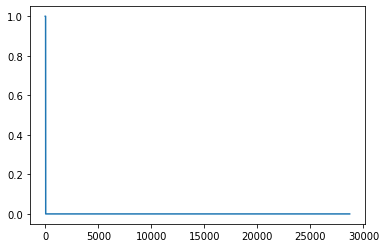

In [0]:
plt.plot(testY)
plt.show()

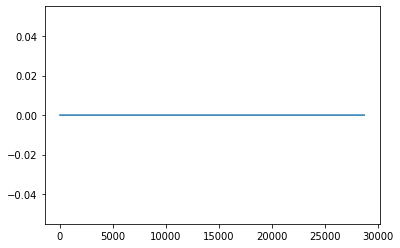

In [0]:
plt.plot(testPredict_class)
plt.show()

### RNN sensitivity with specificity

In [0]:
def create_df_mag(dataset,look_back,rem_range = 500,skip = 50):

  fall_sec = dataset[dataset['fall_value']==1].index.values.tolist()
  dataset = dataset[['accel_base_mag','fall_value']]
  data_df = pd.DataFrame(columns=['X','Y'])
  print('Fall_sec: ',fall_sec)
  
  end_list = []  #edge condition for non-fall values
  start_list = [0]
  #prepare window frame 
  for i in range(len(fall_sec)):
      end_list.append(fall_sec[i] - rem_range)
      start_list.append(fall_sec[i] + rem_range)
  end_list.append(dataset.shape[0]-look_back-1)  
  
  #add fall values
  for i in range(len(fall_sec)):
    # print('row claculating fall: ',fall_sec[i])
    a = dataset.iloc[fall_sec[i]-look_back:fall_sec[i], 0].values
    a = numpy.reshape(a,(100,1,)).tolist()
    b = dataset.iloc[fall_sec[i], 1]
    data_df = data_df.append({'X':a,'Y':b},ignore_index=True)
  print("Added total falls of ",str(len(fall_sec)))
  #add non-fall values
  for start,end in zip(start_list,end_list):
      for i in range(start,end,skip):
        a = dataset.iloc[i:i+look_back, 0].values
        a = numpy.reshape(a,(100,1,)).tolist()
        b = dataset.iloc[i + look_back, 1]
        if(i%100000 == 0):
          print('row claculating',i) 
        data_df = data_df.append({'X':a,'Y':b},ignore_index=True)
  
  # val = data_df.values
  # X = np.reshape(val[:,0].tolist(),(val.shape[0],look_back,1))
  # Y = np.reshape(val[:,1].tolist(),(val.shape[0],1))
  # return X,Y
  return data_df

In [0]:
specificity = 0.99
tpr_tnr_table = pd.DataFrame(columns={'lead time(in ms)','sensitivity','specificity'})
move_window = [10,100,200,300,400,2000]

In [0]:
move_window = [10,100,200,300,400,2000]
look_back = 100
for index in move_window:
  for i in range(1,7):
    temp_df = pd.read_csv('Programs/RNN_features/'+str(index)+"_"+str(i)+'.csv')
    print('calculating for ', i)
    temp_df = create_df_mag(temp_df,look_back)
    temp_df.to_csv("Programs/RNN_sequence_features/"+str(index)+"_"+str(i)+ ".csv", sep=',',index=False)

In [0]:
for index in move_window:
    X = []
    Y = []
    print("reading features on moved window frame by:{} ms".format(index))
    
    for inner_index in range(1,7):
        feature = pd.read_csv("Programs/RNN_sequence_features/"+str(index)+"_"+str(inner_index)+ ".csv")
        val = feature.values
        if i == 1:
          dumtrainX = X
          dumtrainY = Y
        else:
          dumtrainX = np.concatenate((dumtrainX,X))
          dumtrainY = np.concatenate((dumtrainY,Y))
        dumX = np.reshape(val[:,0].tolist(),(val.shape[0],look_back,1))
        dumY = np.reshape(val[:,1].tolist(),(val.shape[0],1))
        X.append(feature[['min_acc','max_acc','right_most']])
        Y.append(feature[['fall_value']])
        
    print("calculating sensitivity on moved window frame by:{} ms".format(index))
    
    sens = cal_sensitivity_with_specificity(X, Y, groups, split_model, model, params,specificity)
    tpr_tnr_table = tpr_tnr_table.append({'lead time(in ms)':index,'sensitivity':round(sens,3),'specificity':(specificity)},
                       ignore_index = True)

## Sensitivity with specificity

In [0]:
specificity = 0.99
tpr_tnr_table = pd.DataFrame(columns={'lead time(in ms)','sensitivity','specificity'})
move_window = [10,100,200,300,400,2000]

In [0]:
for index in move_window:
    X = []
    Y = []
    print("reading features on moved window frame by:{} ms".format(index))
    
    for inner_index in range(1,7):
        feature = pd.read_csv("./3_features/"+str(index)+"_"+str(inner_index)+ ".csv")
        X.append(feature[['min_acc','max_acc','right_most']])
        Y.append(feature[['fall_value']])
        
    print("calculating sensitivity on moved window frame by:{} ms".format(index))
    
    sens = cal_sensitivity_with_specificity(X, Y, groups, split_model, model, params,specificity)
    tpr_tnr_table = tpr_tnr_table.append({'lead time(in ms)':index,'sensitivity':round(sens,3),'specificity':(specificity)},
                       ignore_index = True)

reading features on moved window frame by:10 ms
calculating sensitivity on moved window frame by:10 ms
trail Outer Cross Validation
reading features on moved window frame by:100 ms
calculating sensitivity on moved window frame by:100 ms
trail Outer Cross Validation
reading features on moved window frame by:200 ms
calculating sensitivity on moved window frame by:200 ms
trail Outer Cross Validation
reading features on moved window frame by:300 ms
calculating sensitivity on moved window frame by:300 ms
trail Outer Cross Validation
reading features on moved window frame by:400 ms
calculating sensitivity on moved window frame by:400 ms
trail Outer Cross Validation
reading features on moved window frame by:2000 ms
calculating sensitivity on moved window frame by:2000 ms
trail Outer Cross Validation


In [0]:
tpr_tnr_table.head(6)

,lead time(in ms),specificity,sensitivity
0,10.0,0.99,0.944
1,100.0,0.99,0.664
2,200.0,0.99,0.629
3,300.0,0.99,0.511
4,400.0,0.99,0.395
5,2000.0,0.99,0.006


## ROC graph on moving window

predicting on features by moved window frame by:10 ms
predicting on features by moved window frame by:100 ms
predicting on features by moved window frame by:200 ms
predicting on features by moved window frame by:300 ms
predicting on features by moved window frame by:400 ms
predicting on features by moved window frame by:2000 ms


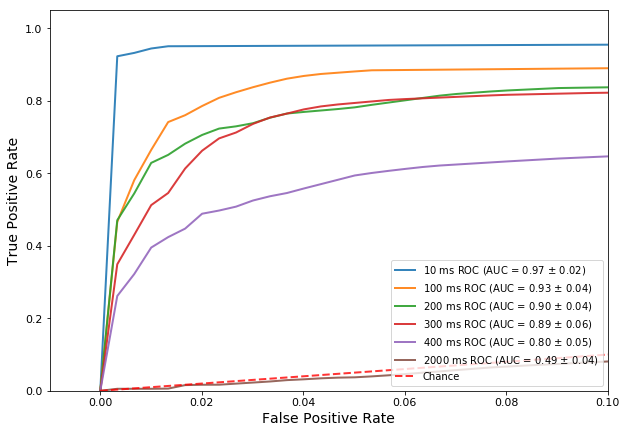

In [0]:
move_window = [10,100,200,300,400,2000]
plt.figure(figsize=(10,7))
auc_values = []
dict_tpr = dict()
dict_fpr = dict()
dict_auc = dict()

for index in move_window:
    X = []
    Y = []
    print("predicting on features by moved window frame by:{} ms".format(index))
    for inner_index in range(1,7):
        feature = pd.read_csv("./3_features/"+str(index)+"_"+str(inner_index)+ ".csv")
        X.append(feature[['min_acc','max_acc','right_most']])
        Y.append(feature[['fall_value']])
    tprs,mean_fpr,aucs = trail_roc_outer_cross_val(X, Y, groups, split_model, model, params)
    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    auc_values.append(round(mean_auc,3))
    std_auc = np.std(aucs)
    dict_tpr[index] = mean_tpr
    dict_fpr[index] = mean_fpr
    dict_auc[index] = aucs
    plt.plot(mean_fpr, mean_tpr,
             label=str(index)+' ms ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
             lw=2, alpha=.9)
    
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
     label='Chance', alpha=.8) 

plt.xlim([-0.01, 0.1])
plt.ylim([0, 1.05])

plt.tick_params(labelsize=11)
plt.xlabel('False Positive Rate',fontsize = 14 )
plt.ylabel('True Positive Rate', fontsize = 14 )
plt.legend(loc="lower right")
img_name = 'ROC_curve'+' ms.png'
plt.savefig(img_name)
plt.show()

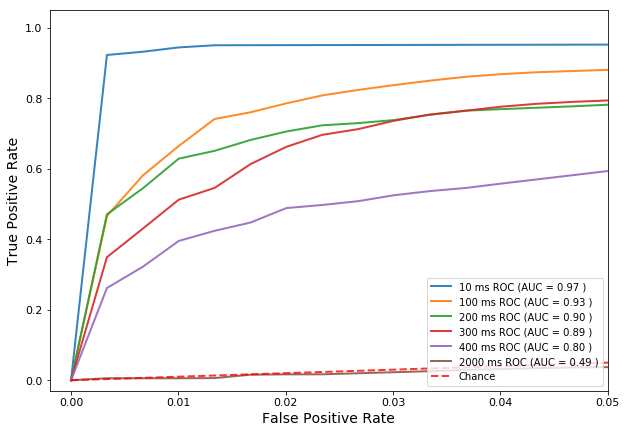

In [0]:
move_window = [10,100,200,300,400,2000]
plt.figure(figsize=(10,7))
auc_values = []

for index in move_window:
    mean_tpr = dict_tpr[index]
    mean_fpr = dict_fpr[index]
    aucs = dict_auc[index] 
    mean_auc = auc(mean_fpr, mean_tpr)
    auc_values.append(round(mean_auc,3))
    std_auc = np.std(aucs)
    plt.plot(mean_fpr, mean_tpr,
             label=str(index)+' ms ROC (AUC = %0.2f )' % (mean_auc),
             lw=2, alpha=.9)
    
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
     label='Chance', alpha=.8) 

plt.xlim([-0.002, 0.05])
plt.ylim([-0.03, 1.05])

plt.tick_params(labelsize=11)
plt.xlabel('False Positive Rate',fontsize = 14 )
plt.ylabel('True Positive Rate', fontsize = 14 )
plt.legend(loc="lower right")
img_name = 'ROC_curve'+' ms.png'
plt.savefig(img_name,bbox_inches='tight')
plt.show()

In [0]:
tpr_tnr_table['AUC'] = auc_values

In [0]:
tpr_tnr_table.head(7)

,lead time(in ms),specificity,sensitivity,AUC
0,10,0.99,0.944,0.973
1,100,0.99,0.664,0.932
2,200,0.99,0.629,0.901
3,300,0.99,0.511,0.892
4,400,0.99,0.395,0.796
5,2000,0.99,0.006,0.494


In [0]:
# tpr_tnr_table['lead time(in ms)'] = tpr_tnr_table['lead time(in ms)'].astype('int64')
new_df = tpr_tnr_table.drop('specificity',axis=1)
new_df.head(7)

,lead time(in ms),sensitivity,AUC
0,10,0.944,0.973
1,100,0.664,0.932
2,200,0.629,0.901
3,300,0.511,0.892
4,400,0.395,0.796
5,2000,0.006,0.494


In [0]:
df =pd.DataFrame( {'Lead time\n(in ms)':[ 10,100,200,300,400,2000 ], 
               'Sensitivity': ['94.4%','66.4%','62.9%','51.1%','39.5%','0.6%'],
                'AUC':[ 0.973,0.932,0.901,0.892,0.796,0.494]})
df.to_csv('results.csv')

In [0]:
rd = pd.read_csv('change.csv')

In [0]:
rd.head(7)

,Lead time (in ms),Sensitivity,AUC
0,10,94.40%,0.973
1,100,66.40%,0.932
2,200,62.90%,0.901
3,300,51.10%,0.892
4,400,39.50%,0.796
5,2000,0.60%,0.494


In [0]:
new_df['sensitivity'] = new_df['sensitivity'].apply(lambda x : str(round(x*100,1))+" %") 

In [0]:
new_df

,lead time(in ms),sensitivity,AUC
0,10,94.4 %,0.973
1,100,66.4 %,0.932
2,200,62.9 %,0.901
3,300,51.1 %,0.892
4,400,39.5 %,0.796
5,2000,0.6 %,0.494
